In [4]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Transformer##

트랜스포머는 어텐션을 이용하는 인코더-디코더 구조의 모델입니다.
트랜스포머 기반의 language model은 NLP의 많은 task에서 좋은 성능을 보여줍니다.

트랜스포머는 후에 많은 nlp모델에 영향을 끼쳤습니다. 우리에게 익숙한 GPT도 트랜스포머를 이용한 모델입니다. (말하자면 사전학습된 트랜스포머입니다)

이번 과제에서는 hugging face와 GPT에 관해 간략히 소개하고 챗봇을 구성해보겠습니다



##hugging face 🤗##

허깅페이스는 여러 분야의 가장 좋은 성능을 내는 딥러닝 모델을 쉽게 사용할 수 있는 인터페이스를 제공합니다.

허깅페이스의 transformers 라이브러리는 모델을 사용하기 위한 전처리, 학습, 배포와 관련된 편의기능을 제공합니다.

허깅페이스의 꽃이라고 할 수있는 인터페이스는 pipeline입니다. 이번에는 사용하지 않을 것이지만 모델을 다운받지 않고도 전처리부터 예측까지 한줄의 코드로 진행해줍니다. (https://huggingface.co/docs/transformers/main_classes/pipelines)

In [6]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.4 MB/s eta 0:00:00


전처리를 위해 kogpt를 학습할 때 사용된 토크나이저를 가져와 줍니다. 학습된 토크나이저를 from_pretrained를 이용해 간편하게 불러올 수 있습니다.

이것으로 저희 챗봇 데이터셋을 가공하고 챗봇을 만드는 데 사용해 보겠습니다!

In [7]:
from transformers import PreTrainedTokenizerFast, GPT2LMHeadModel

In [9]:
BOS = "[BOS]" # Beginning of sentence
SEP = "[SEP]" # seperator
EOS = "[EOS]" # end of sentence
PAD = "[PAD]" # padding

tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
            unk_token='<unk>', pad_token=PAD, eos_token=EOS,
            bos_token=BOS, sep_token=SEP)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [10]:
print(tokenizer.bos_token_id)
print(tokenizer.eos_token_id)
print(tokenizer.sep_token_id)
print(tokenizer.pad_token_id) # QA학습에 사용할 토큰들이 잘 저장되었습니다.

51200
51201
51202
51203


In [11]:
tokenizer.encode("안녕하세요 오늘 날씨가 좋아요")

[25906, 8702, 7801, 8084, 10070, 34018, 12011, 8084]

In [12]:
tokenizer.decode([25906, 8702, 7801, 8084, 10070, 34018, 12011, 8084])

'안녕하세요 오늘 날씨가 좋아요'

In [13]:
# 파이토치, 넘파이, 텐서플로 등에 맞춰 반환형태를 지정할 수 있고 패딩, 배칭도 진행해줍니다.
tokenizer(
    ["안녕하세요 오늘 날씨가 엄청 좋아요", "만나서 반가워요"],
    return_tensors="pt", truncation=True, padding='max_length',
    max_length=10
)

{'input_ids': tensor([[25906,  8702,  7801,  8084, 10070, 34018, 15546, 12011,  8084, 51203],
        [11667,  7788, 36230,  8102,  8084, 51203, 51203, 51203, 51203, 51203]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]])}

## GPT ##

우리에게 익숙한 LM인 GPT는 Generative Pretrained Transformer의 약자입니다.

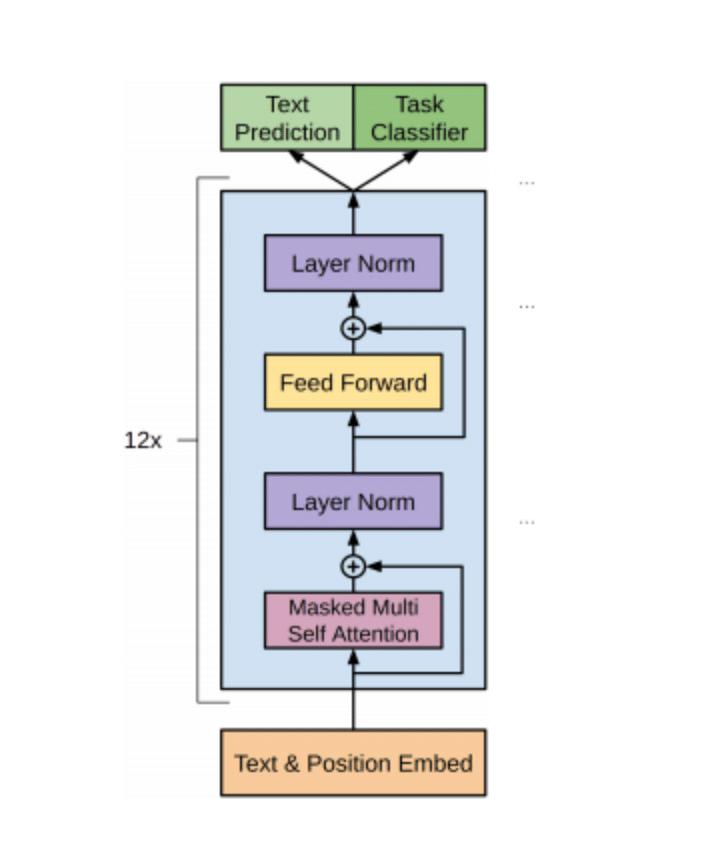

GPT의 구조를 유심히 보시면 Transformer의 Decoder를 사용한 것입니다. 인터넷 상의 방대한 일반적인 텍스트로 Transformer Decoder를 Pre-Train(사전 학습)시켜 기계번역, QA, 텍스트 요약 등 다양한 downstream task에 다시 학습(전이 학습, Transfer Learning)시키는 접근 방식입니다.

seq2seq, 트랜스포머를 이용해 챗봇을 만들어 봤으니 이번엔 GPT를 이용해봅시다!

허깅페이스엔 다양한 데이터로 학습된 모델이 공유되어 있습니다. 저희가 이번에 사용할 kogpt2는 skt에서 한국어 기사를 학습시켜 배포한 모델입니다. (https://github.com/SKT-AI/KoGPT2) transformer 모듈에는 분야별 딥러닝 모델들이 정리되어 있습니다. from_pretrained를 이용해 모델의 구조와 파라미터를 간단하게 불러올 수 있습니다!

In [14]:
import pandas as pd
from transformers import get_linear_schedule_with_warmup, AdamW

import torch
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

In [15]:
kogpt2 = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2')

kogpt2.resize_token_embeddings(len(tokenizer)) # 모델에도 추가한 토큰 임베딩을 만들어줍니다.

Embedding(51204, 768)

저희가 가진 챗봇 데이터셋의 대화를 하나로 이어 데이터셋을 구성해줍니다.

BOS + 사람의 질문 + SEP + 챗봇의 대답 + EOS 가 하나의 샘플이 될 것입니다.

In [16]:
MAX_LENGTH = 53 # Q + A + 토큰 3개

class GPTDataset(Dataset):
    def __init__(self, tokenizer, file_path):
        data = pd.read_csv(file_path)
        concats = [ BOS + Q + SEP + A + EOS for Q, A in zip(data["Q"], data["A"]) ]

        self.QApairs = tokenizer(
            concats,
            return_tensors="pt", # pytorch tensor로 반환해줍니다
            padding='max_length', truncation=True,  # 주어진 max_length에 맞춰줍니다
            max_length=MAX_LENGTH,
        )["input_ids"] # ( Q&A pairs 개수, _ )

        self.length = len(concats)

    def __getitem__(self, i):
        return self.QApairs[i]

    def __len__(self):
        return self.length

In [17]:
# 챗봇 데이터셋 경로를 지정해주세요!
CSV_PATH = "/content/drive/MyDrive/ChatbotData.csv"

dataset = GPTDataset(tokenizer, CSV_PATH)

dataloader = DataLoader(dataset, batch_size=32, pin_memory=True, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


이제 학습시켜볼까요?? 적당한 옵티마이저, 스케쥴러를 이용해 우리가 가지고 있는 챗봇과의 대화를 학습시킵시다.

우리의 데이터셋은 사람과 모델의 대화를 이어 하나의 샘플로 제공해주기 때문에 대화의 첫 단어 부터 다음 단어, 그 다음 단어를 예측하도록 causalLM(순서대로 다음 단어를 예측하는 언어모델)의 GPT2LMHead 모델을 가져와 줍니다. (GPT2에 다음 단어를 예측하는 head를 붙인 모델이라는 뜻입니다. 체크포인트(skt/kogpt2-base-v2)를 지정하면 skt에서 올려놓은 모델을 불러옵니다. )

gpt에 input과 output으로 같은 문장을 넣어주면 gpt는 '각 위치의 다음단어를 예측한 확률 오차(nllLoss)'를 계산해 평균을 내줍니다. 이 오차가 0이 되도록 학습한 언어모델을 auto-regressive LM이라고도 부릅니다.

In [18]:
# @title
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
kogpt2.to(device)
kogpt2.train()

optimizer = AdamW(kogpt2.parameters(), lr=0.001)
# warmup_step 부터 서서히 학습률이 감소하는 linear 스케쥴링을 가합니다.
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=1000, num_training_steps=-1
)

EPOCHS = 10
for epoch in range(EPOCHS):
  print(f"Training epoch {epoch+1}:")

  for text in tqdm(dataloader):
    input = text.to(device)
    output = kogpt2(input_ids=input, labels=input)
    loss = output.loss # causal LM의 Loss를 간단하게 구해줍니다. (auto-regressive LM)

    optimizer.zero_grad()
    kogpt2.zero_grad()
    loss.backward()

    optimizer.step()
    scheduler.step()

  print(f"epoch {epoch+1} loss : {loss.item()}")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training epoch 1:


100%|██████████| 370/370 [02:59<00:00,  2.06it/s]


epoch 1 loss : 1.6367892026901245
Training epoch 2:


100%|██████████| 370/370 [02:57<00:00,  2.09it/s]


epoch 2 loss : 1.3799129724502563
Training epoch 3:


100%|██████████| 370/370 [02:57<00:00,  2.09it/s]


epoch 3 loss : 2.94122314453125
Training epoch 4:


100%|██████████| 370/370 [02:56<00:00,  2.09it/s]


epoch 4 loss : 2.9384055137634277
Training epoch 5:


100%|██████████| 370/370 [02:56<00:00,  2.10it/s]


epoch 5 loss : 2.9449503421783447
Training epoch 6:


100%|██████████| 370/370 [02:56<00:00,  2.10it/s]


epoch 6 loss : 2.9342434406280518
Training epoch 7:


100%|██████████| 370/370 [02:56<00:00,  2.10it/s]


epoch 7 loss : 2.9452927112579346
Training epoch 8:


100%|██████████| 370/370 [02:56<00:00,  2.10it/s]


epoch 8 loss : 2.9372947216033936
Training epoch 9:


100%|██████████| 370/370 [02:56<00:00,  2.10it/s]


epoch 9 loss : 2.951740264892578
Training epoch 10:


100%|██████████| 370/370 [02:56<00:00,  2.10it/s]

epoch 10 loss : 2.9423770904541016


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


( 10에폭은 gpt를 학습시키기에 충분한 에폭 수는 아닙니다. 그렇지만 학습 시간이 꽤 길어 10에폭만 학습시키고 실험해보겠습니다!  )

In [19]:
prompts = "썸녀에게 만나자고 물어볼까?"

kogpt2.eval()

tokenized_prompt = tokenizer("[BOS]" + prompts + "[SEP]", return_tensors="pt")['input_ids'].to(device)

gen_ids = kogpt2.generate(
            tokenized_prompt,
            max_length=53,
            repetition_penalty=2.0,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
            bos_token_id=tokenizer.bos_token_id,
            use_cache=True,
            do_sample=True,
        )

sentence = tokenizer.decode(gen_ids[0])

# 챗봇의 대답부분을 자르고 unkown token을 제거합니다.
if "[EOS]" in sentence:
  sentence = sentence[sentence.index("[SEP]") + 5 : sentence.index("[EOS]")]
else:
  sentence = sentence[sentence.index("[SEP]") + 5 :]

sentence = sentence.replace("<unk>", " ").split("\n")[0]

print(prompts)
print("사랑꾼 심심이 👶🏻 :", sentence)

썸녀에게 만나자고 물어볼까?
사랑꾼 심심이 👶🏻 : 




수고 많으셨습니다!! 과제는 학습시킨 챗봇에게 질문하고 얻은 답변을 아래 처럼 캡쳐해서 올려주세요.

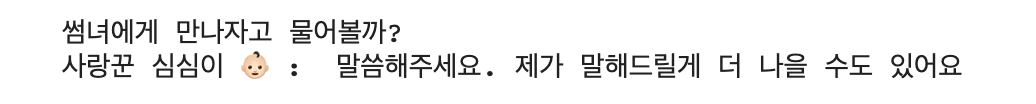

쉽지 않은 내용이지만 집중해서 들어주셔서 감사하고 모두 수고 많으셨습니다🙇‍♂️